# An example of fitting the synthetic nascent signal data

In [1]:
using CSV, DataFrames
using Plots; theme(:vibrant)
using RNAInferenceTool, StatsBase

## Import data and load SSA functions

In [2]:
# Import SSA code install delay SSA package at https://github.com/palmtree2013/DelaySSAToolkit.jl
include("delaytelegraphSSA.jl")
# Parameters 
τ = 0.5
tf = 20 
params = [1.0526,8.2034,57.989,0,0,τ,tf] # σ_off, σ_on, ρ_on, ρ_off, d, τ, SSA final time
L1 = 862; L = 3062; # L1 =  signal fluorescence 862 bp; L = total gene 3062 bp 

3062

## Generate synthetic SSA signal data

In [3]:
numofRun = 10000 # delay SSA sample size
djprob = construct_prob_delaytelegraph(params)
ens_prob = EnsembleProblem(djprob)
ens = solve(ens_prob, SSAStepper(), EnsembleSerial(), trajectories = numofRun);

## Check the distribution

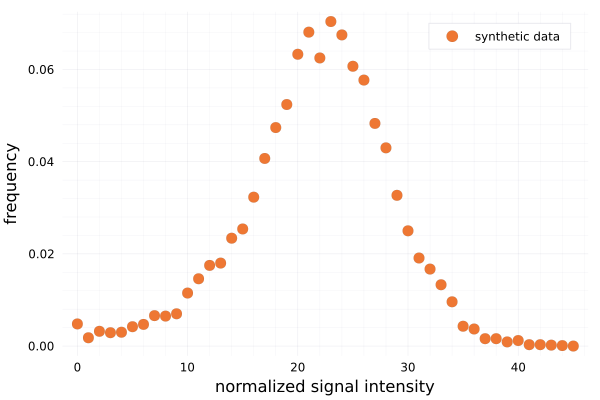

In [4]:
filter_pos_tf = [ens[i].channel[end][1] for i in eachindex(ens)]
res_ens = [signal_function.(filter_pos_tf[i], τ = τ, L1 = L1, L = L) for i in eachindex(filter_pos_tf)]
histo_synthetic = sum_with_non.(res_ens)
scatter(convert_histo(histo_synthetic), labels="synthetic data", xlabel = "normalized signal intensity", ylabel = "frequency") # plot distribution

 # Inference

## load functions and set parameters

In [5]:
#For delay model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d, τ
SRange = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(0.0,0.0),(τ,τ)];

#For telegraph model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d
SRange_tele = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(1/τ,1/τ)];

Next, we set the data structure for inference `OptimStruct`, which consists of the following elements:

1. data: default type is histogram data (in this work and the following demo, we used this type of data); the other additional supported type is to use probability distribution.
2. stage: `G1()` or `G2()`; where `G2()` type data is inferred by convolution of two G1 stage distribution.
3. dist: the distance function: `Likelihood()`, `Likelihood_fusion()`, `Likelihood_rejection()` and other distance functions in Distances.jl package are supported.
4. model: telegraph model `Telegraph()`, delay telegraph model `Delay()`, and Poisson model `Poisson()` are supported.
   
Keywords arguments:
1. infer_counts: Bool type, `true` if the inferred histogram data is the product count (e.g. the number of Pol II attached to the gene), `false` if the histogram data is the normalized signal intensity (e.g. signal affected by the PP7 Loop).
2. L1 and L2: if `infer_counts` is set to `false` then L1 and L2 must be provided which represents the respective length of the linear part and plateau part of the trapezoid signal function respectively.

In [6]:
infer_struct = OptimStruct(histo_synthetic, G1(), Likelihood(), Delay(); infer_counts = false, L1 = 862, L2 =2200)
infer_struct_tele = OptimStruct(histo_synthetic, G1(), Likelihood(), Telegraph(); infer_counts = false, L1 = 862, L2 =2200)

OptimStruct{G1, Likelihood, Telegraph, Int64}([23.623827110195272, 27.586975359781764, 19.973089523834226, 20.933262537194075, 22.90795640951992, 20.38531082553138, 19.81932756000821, 29.265350138604987, 17.169679259668513, 24.91489665894916  …  27.72323265764001, 35.202389732135316, 21.069857405199524, 21.803522807324267, 11.0, 22.664645102740536, 15.0, 16.242406301749547, 16.591829977676667, 34.3110463456677], G1(), Likelihood(), Telegraph(), true, false, 862, 2200)

In [7]:
estimated_params, distributions = optim_function(SRange, infer_struct, MaxFuncEvals = 10000)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 90 evals, 49 steps

, improv/step: 0.469 (last = 0.4694), fitness=33141.778128786


1.01 secs, 199 evals, 128 steps, improv/step: 0.445 (last = 0.4304), fitness=33141.778128786
1.51 secs, 336 evals, 257 steps

, improv/step: 0.397 (last = 0.3488), fitness=32881.902697583


2.01 secs, 456 evals, 379 steps, improv/step: 0.361 (last = 0.2869), fitness=32881.902697583
2.51 secs, 581 evals, 508 steps

, improv/step: 0.321 (last = 0.2016), fitness=32881.902697583


3.02 secs, 710 evals, 653 steps, improv/step: 0.292 (last = 0.1931), fitness=32881.902697583
3.52 secs, 847 evals, 803 steps

, improv/step: 0.275 (last = 0.2000), fitness=32881.902697583


4.02 secs, 974 evals, 947 steps, improv/step: 0.250 (last = 0.1111), fitness=32881.902697583
4.52 secs, 1114 evals, 1102 steps

, improv/step: 0.233 (last = 0.1290), fitness=32881.902697583


5.02 secs, 1251 evals, 1256 steps, improv/step: 0.229 (last = 0.2013), fitness=32881.902697583
5.53 secs, 1385 evals, 1409 steps

, improv/step: 0.224 (last = 0.1765), fitness=32774.484308863


6.03 secs, 1513 evals, 1548 steps, improv/step: 0.218 (last = 0.1655), fitness=32773.160945255
6.53 secs, 1643 evals, 1696 steps

, improv/step: 0.212 (last = 0.1486), fitness=32736.173948500


7.04 secs, 1781 evals, 1856 steps, improv/step: 0.209 (last = 0.1750), fitness=32736.173948500
7.54 secs, 1915 evals, 2007 steps

, improv/step: 0.206 (last = 0.1656), fitness=32732.530858174


8.04 secs, 2033 evals, 2137 steps, improv/step: 0.208 (last = 0.2462), fitness=32722.490594259
8.54 secs, 2159 evals, 2283 steps

, improv/step: 0.207 (last = 0.1918), fitness=32715.766212893


9.05 secs, 2288 evals, 2432 steps, improv/step: 0.204 (last = 0.1611), fitness=32712.329520682
9.55 secs, 2425 evals, 2589 steps

, improv/step: 0.201 (last = 0.1529), fitness=32712.329520682


10.05 secs, 2564 evals, 2748 steps, improv/step: 0.200 (last = 0.1824), fitness=32711.719329288
10.55 secs, 2685 evals, 2887 steps

, improv/step: 0.201 (last = 0.2086), fitness=32711.719329288


11.05 secs, 2825 evals, 3058 steps, improv/step: 0.201 (last = 0.2164), fitness=32711.716915346
11.55 secs, 2937 evals, 3177 steps

, improv/step: 0.201 (last = 0.1933), fitness=32711.716915346


12.05 secs, 3054 evals, 3312 steps, improv/step: 0.202 (last = 0.2148), fitness=32711.427524702
12.55 secs, 3179 evals, 3456 steps

, improv/step: 0.201 (last = 0.1736), fitness=32711.427524702


13.05 secs, 3308 evals, 3601 steps, improv/step: 0.200 (last = 0.2000), fitness=32711.427524702
13.56 secs, 3447 evals, 3765 steps

, improv/step: 0.199 (last = 0.1707), fitness=32711.427524702


14.06 secs, 3582 evals, 3923 steps, improv/step: 0.199 (last = 0.1962), fitness=32711.427524702
14.56 secs, 3711 evals, 4068 steps

, improv/step: 0.199 (last = 0.2000), fitness=32711.427524702


15.07 secs, 3849 evals, 4222 steps, improv/step: 0.202 (last = 0.2727), fitness=32711.427524702
15.58 secs, 3972 evals, 4357 steps

, improv/step: 0.202 (last = 0.2222), fitness=32711.416350506


16.08 secs, 4086 evals, 4484 steps, improv/step: 0.200 (last = 0.1102), fitness=32711.416350506
16.58 secs, 4203 evals, 4612 steps

, improv/step: 0.202 (last = 0.2812), fitness=32711.416350506


17.08 secs, 4336 evals, 4762 steps, improv/step: 0.202 (last = 0.2067), fitness=32711.415294123
17.58 secs, 4473 evals, 4913 steps

, improv/step: 0.203 (last = 0.2318), fitness=32711.415175407


18.09 secs, 4595 evals, 5059 steps, improv/step: 0.202 (last = 0.1712), fitness=32711.415175407
18.59 secs, 4736 evals, 5212 steps

, improv/step: 0.205 (last = 0.2810), fitness=32711.415122931


19.10 secs, 4879 evals, 5377 steps, improv/step: 0.206 (last = 0.2364), fitness=32711.415088973
19.60 secs, 5016 evals, 5530 steps

, improv/step: 0.206 (last = 0.2222), fitness=32711.415088973


20.10 secs, 5158 evals, 5699 steps, improv/step: 0.206 (last = 0.1953), fitness=32711.415087633
20.60 secs, 5276 evals, 5831 steps

, improv/step: 0.206 (last = 0.2273), fitness=32711.415068909


21.10 secs, 5416 evals, 5991 steps, improv/step: 0.206 (last = 0.1938), fitness=32711.415065089
21.61 secs, 5547 evals, 6140 steps

, improv/step: 0.206 (last = 0.2081), fitness=32711.415065089


22.11 secs, 5672 evals, 6282 steps, improv/step: 0.205 (last = 0.1690), fitness=32711.415065085
22.61 secs, 5807 evals, 6437 steps

, improv/step: 0.205 (last = 0.2194), fitness=32711.415064894


23.12 secs, 5930 evals, 6576 steps, improv/step: 0.205 (last = 0.1727), fitness=32711.415064894
23.62 secs, 6060 evals, 6725 steps

, improv/step: 0.206 (last = 0.2617), fitness=32711.415064612


24.12 secs, 6195 evals, 6874 steps, improv/step: 0.205 (last = 0.1678), fitness=32711.415064612
24.62 secs, 6327 evals, 7013 steps

, improv/step: 0.206 (last = 0.2518), fitness=32711.415064574


25.12 secs, 6464 evals, 7172 steps, improv/step: 0.206 (last = 0.1950), fitness=32711.415064395
25.63 secs, 6602 evals, 7330 steps

, improv/step: 0.206 (last = 0.2089), fitness=32711.415064395


26.13 secs, 6737 evals, 7493 steps, improv/step: 0.206 (last = 0.2025), fitness=32711.415064395
26.63 secs, 6861 evals, 7641 steps

, improv/step: 0.207 (last = 0.2500), fitness=32711.415064395


27.13 secs, 7002 evals, 7800 steps, improv/step: 0.207 (last = 0.2327), fitness=32711.415064389
27.63 secs, 7140 evals, 7947 steps

, improv/step: 0.207 (last = 0.2177), fitness=32711.415064389


28.13 secs, 7278 evals, 8104 steps, improv/step: 0.207 (last = 0.1656), fitness=32711.415064389
28.63 secs, 7417 evals, 8259 steps

, improv/step: 0.207 (last = 0.2065), fitness=32711.415064385


29.13 secs, 7538 evals, 8391 steps, improv/step: 0.207 (last = 0.2576), fitness=32711.415064385
29.64 secs, 7675 evals, 8543 steps

, improv/step: 0.207 (last = 0.1842), fitness=32711.415064385


30.14 secs, 7822 evals, 8707 steps, improv/step: 0.207 (last = 0.2012), fitness=32711.415064384
30.64 secs, 7947 evals, 8853 steps

, improv/step: 0.207 (last = 0.1986), fitness=32711.415064383


31.14 secs, 8078 evals, 9001 steps, improv/step: 0.207 (last = 0.2230), fitness=32711.415064383
31.65 secs, 8211 evals, 9148 steps

, improv/step: 0.207 (last = 0.2041), fitness=32711.415064383


32.15 secs, 8345 evals, 9305 steps, improv/step: 0.207 (last = 0.2038), fitness=32711.415064383
32.65 secs, 8480 evals, 9456 steps

, improv/step: 0.207 (last = 0.1921), fitness=32711.415064383


33.15 secs, 8616 evals, 9619 steps, improv/step: 0.206 (last = 0.1534), fitness=32711.415064383
33.65 secs, 8743 evals, 9760 steps

, improv/step: 0.206 (last = 0.2411), fitness=32711.415064383


34.15 secs, 8883 evals, 9914 steps, improv/step: 0.206 (last = 0.2013), fitness=32711.415064383
34.65 secs, 9027 evals, 10068 steps

, improv/step: 0.206 (last = 0.2143), fitness=32711.415064383


35.16 secs, 9157 evals, 10216 steps, improv/step: 0.205 (last = 0.1149), fitness=32711.415064383
35.66 secs, 9282 evals, 10371 steps

, improv/step: 0.204 (last = 0.1161), fitness=32711.415064383


36.16 secs, 9425 evals, 10534 steps, improv/step: 0.202 (last = 0.0920), fitness=32711.415064383
36.66 secs, 9567 evals, 10696 steps

, improv/step: 0.200 (last = 0.0617), fitness=32711.415064383


37.16 secs, 9686 evals, 10841 steps, improv/step: 0.198 (last = 0.0828), fitness=32711.415064383
37.66 secs, 9820 evals, 10992 steps

, improv/step: 0.196 (last = 0.0199), fitness=32711.415064383


38.17 secs, 9959 evals, 11149 steps, improv/step: 0.194 (last = 0.0573), fitness=32711.415064383

Optimization stopped after 11196 steps and 38.35 seconds


Termination reason: Max number of function evaluations (10000) reached
Steps per second = 291.95
Function evals per second = 260.79
Improvements/step = Inf
Total function evaluations = 10001


Best candidate found: [0.842589, 7.15947, 57.4641, 0.0, 0.0, 0.5]

Fitness: 32711.415064383



([0.8425885552978046, 7.1594675099875245, 57.46413393774614, 0.0, 0.0, 0.5, 32711.415064383247], [0.004488773943807951 0.0048; 0.001933160763253262 0.0018; … ; 2.2055836291186225e-9 0.0; 1.0018864587686138e-10 0.0])

In [8]:
estimated_params_tele, distributions_tele = optim_function(SRange_tele, infer_struct_tele, MaxFuncEvals = 10000)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1921 evals, 2002 steps

, improv/step: 0.211 (last = 0.2108), fitness=32826.178913599


1.00 secs, 4017 evals, 4326 steps, improv/step: 0.195 (last = 0.1816), fitness=32742.237396827
1.50 secs, 6128 evals, 6655 steps

, improv/step: 0.206 (last = 0.2271), fitness=32742.151465303


2.00 secs, 8255 evals, 9021 steps, improv/step: 0.210 (last = 0.2198), fitness=32742.151440326

Optimization stopped after 10959 steps and 2.41 seconds


Termination reason: Max number of function evaluations (10000) reached
Steps per second = 4548.01
Function evals per second = 4150.43
Improvements/step = Inf
Total function evaluations = 10001


Best candidate found: [0.364624, 3.02556, 57.5479, 0.0, 2.0]

Fitness: 32742.151440324



([0.36462400095870756, 3.0255608518751003, 57.54785755239803, 0.0, 2.0, 32742.151440324236], [0.0017824066258088247 0.0048; 0.002688376935500537 0.0018; … ; 2.0591190867144557e-9 0.0; 9.358844642099122e-11 0.0])

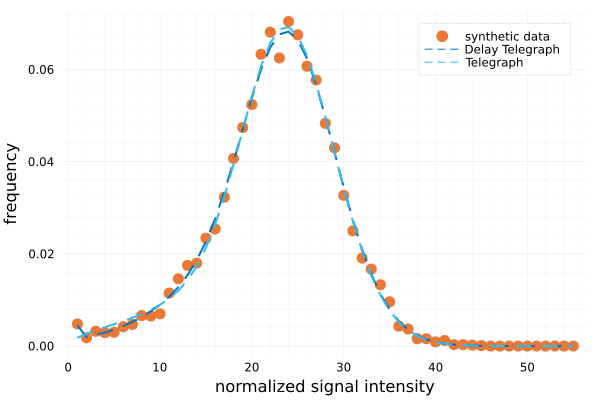

In [9]:
scatter(distributions[:,2],labels="synthetic data", xlabel = "normalized signal intensity", ylabel = "frequency")
plot!([distributions[:,1] distributions_tele[:,1]],lines=(2, :dash),labels=["Delay Telegraph" "Telegraph"])

In [10]:
#Compare the paramters
DataFrame(True = params[1:3],Delay=estimated_params[1:3],Telegraph= estimated_params_tele[1:3])

,True,Delay,Telegraph
,Float64,Float64,Float64
1,1.0526,0.842589,0.364624
2,8.2034,7.15947,3.02556
3,57.989,57.4641,57.5479
